# Inteligentná analýza údajov 2019/2020 - Projekt
## Druhá časť - predspracovanie
## Ondrej Jedinák, František Tibenský

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

pd.options.display.max_colwidth=130
pd.set_option("display.max_columns", None)

## Konfigurácia

In [2]:
IN_PERSONAL = "data/personal_train.csv"
IN_OTHER = "data/other_train.csv"
OUT = "preprocessed.csv"
DATUM = "now"

## ---------------------

In [3]:
personal_data = pd.read_csv(IN_PERSONAL, index_col=0)
data = pd.read_csv(IN_OTHER, index_col=0)

In [4]:
for ds in [personal_data, data]:
    cls=ds.columns
    cl2=[]
    for cl in cls:
        cl2.append(cl.replace("-","_"))
    ds.rename(columns={i:j for i,j in zip(cls,cl2)}, inplace=True)

Nastavíme konzistentné názvy atribútov pre lepšiu prehľadnosť.

In [5]:
for ds in [data, personal_data]:
    for col in ds:
        if ds[col].dtype=='object':
            ds[col]=ds[col].str.strip()

data=data.replace('?',np.NaN)
data=data.replace('??',np.NaN)

Odstránime zo všetkých textových atribútov prázdne znaky na začiatku a konci a zmeníme hodnoty s otáznikmi na NaN.

In [6]:
display(personal_data.head())
data.head()

,name,address,age,sex,date_of_birth
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH 53211",58,Male,1961-03-11
1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN 57550",56,Female,1962/11/20
2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",59,Male,11/12/1959
3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",66,Female,1953-03-18
4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 77139",64,Male,1954-12-12


,name,address,race,marital_status,occupation,pregnant,education_num,relationship,skewness_glucose,mean_glucose,capital_gain,kurtosis_glucose,education,fnlwgt,class,std_glucose,income,medical_info,native_country,hours_per_week,capital_loss,workclass
0,Ernest Valles,"698 Miller Gateway Apt. 970\r\nClayside, ND 13457",White,Married-civ-spouse,Adm-clerical,f,10.0,Husband,0.198684,105.859375,0.0,0.222954,Some-college,343789.0,0.0,48.744348,>50K,"{'mean_oxygen':'0.790133779','std_oxygen':'10.13249696','kurtosis_oxygen':'17.68151382','skewness_oxygen':'374.9257754'}",United-States,40.0,0.0,State-gov
1,Michael Kowal,"4784 Walters Extensions\r\nEast Whitney, NH 27458",White,NaN,Sales,F,13.0,Not-in-family,-0.334631,120.453125,0.0,-0.049047,Bachelors,188957.0,0.0,50.982512,<=50K,"{'mean_oxygen':'18.69147157','std_oxygen':'51.21049055','kurtosis_oxygen':'2.541428789','skewness_oxygen':'4.930561896'}",United-States,40.0,0.0,Self-emp-not-inc
2,Mike Rogers,"068 Baker Estates Apt. 300\r\nRoberttown, NV 50205",White,Married-civ-spouse,Sales,f,13.0,Husband,0.030878,117.257812,0.0,0.121774,Bachelors,112283.0,0.0,42.893263,<=50K,"{'mean_oxygen':'1.150501672','std_oxygen':'11.49825164','kurtosis_oxygen':'16.48789423','skewness_oxygen':'320.6702352'}",United-States,55.0,0.0,Private
3,Marvin Cherry,"75326 Odom Drive\r\nNorth Robert, SC 99612",White,Married-civ-spouse,Farming-fishing,f,9.0,Husband,0.636882,99.429688,0.0,0.349696,HS-grad,166416.0,0.0,43.658777,<=50K,"{'mean_oxygen':'0.387123746','std_oxygen':'8.683190316000001','kurtosis_oxygen':'25.389201','skewness_oxygen':'685.06342239999...",United-States,99.0,0.0,Self-emp-not-inc
4,Bernard Williams,"258 Valerie Throughway\r\nSouth Samanthafort, TX 69130",Black,Widowed,Other-service,f,700.0,Not-in-family,0.105785,109.382812,0.0,0.232842,11th,462440.0,0.0,48.991568,<=50K,"{'mean_oxygen':'0.945652174','std_oxygen':'12.0495586','kurtosis_oxygen':'14.8422644','skewness_oxygen':'245.358921'}",United-States,20.0,0.0,Private


## date_of_birth

Tento atribút má nekonzistentné formáty dátumov.

Možne formáty dátumov:

1. yyyy-mm-dd
1. yyyy/mm/dd
1. yy-mm-dd
1. dd/mm/yyyy
1. yyyy-mm-dd 00:00:00
1. yyyy-mm-dd 00 00 00


In [7]:
personal_data["date_of_birth"]=personal_data["date_of_birth"].str.replace(" .*","")
personal_data["date_of_birth"]=personal_data["date_of_birth"].str.replace("/","-")
personal_data['date_of_birth']=personal_data['date_of_birth'].str.replace(r'([0-9]{2})-([0-9]{2})-([0-9]{4})', r'\3-\2-\1')

personal_data['date_of_birth']=personal_data['date_of_birth'].str.replace(r'^(19-[0-9]{2}-[0-9]{2})',r'19\1')
personal_data['date_of_birth']=personal_data['date_of_birth'].str.replace(r'^([2-9][0-9]-[0-9]{2}-[0-9]{2})',r'19\1')
personal_data['date_of_birth']=personal_data['date_of_birth'].str.replace(r'^([0-1][0-9]-[0-9]{2}-[0-9]{2})',r'20\1')

chceme všetky dátumy dostať do 1. formátu
- odstránime časové hodnoty
- zmeníme všetky / na -
- prehodíme rok a deň pri 4. prípade
- doplníme prvé dve cifry roku pre 3. prípad

In [8]:
personal_data["date_of_birth"].str.contains("(^[0-9]{4}-((0[0-9])|(1[0-2]))-([0-2][0-9]|(3)[0-1])$)").unique()

D:\Python\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


array([ True])

Kontrola či sú formáty jednotné.

## age

Zistíme rozdiely vo vekoch a dátumoch narodenia.

In [9]:
((pd.to_datetime(DATUM)-pd.to_datetime(personal_data["date_of_birth"])).astype('<m8[Y]')-personal_data["age"]).value_counts()

0.0    3620
1.0     313
dtype: int64

V dátumoch narodenia a vekoch nie sú žiadne výrazné nezrovnalosti. Jediný problém je že niektoré veky neboli aktualizované pre aktuálny dátum. Tiež neexistuje žiaden dátum pre ktorý by neboli aspoň niektoré veky o jeden rok posunuté. Preto si nanovo vypočítame veky k jednotnému dátumu.

In [10]:
personal_data["age"]=((pd.to_datetime(DATUM)-pd.to_datetime(personal_data["date_of_birth"])).astype('<m8[Y]'))

Keďže nám bude ďalej celý dátum narodenia zbytočný lebo máme vek, ponecháme len mesiac narodenia.

In [11]:
personal_data['date_of_birth']=personal_data['date_of_birth'].str.replace(r'([0-9]{4})-([0-9]{2})-([0-9]{2})', r'\2').astype(str).astype(float)
personal_data.rename(columns={"date_of_birth": "birth_month"},inplace=True)

## workclass

Opravíme nekonzistentné začiatočné písmená.

In [12]:
data["workclass"]=data["workclass"].str.capitalize()
data["workclass"].value_counts(dropna=False)

Private             2737
Self-emp-not-inc     304
Local-gov            266
NaN                  256
State-gov            146
Self-emp-inc         145
Federal-gov          125
Without-pay            3
Never-worked           1
Name: workclass, dtype: int64

## rozdelenie medical_data

In [13]:
data['medical_info']=data['medical_info'].replace(np.NaN,"{}")
data['medical_info']=data['medical_info'].str.replace("'",'"')
data=data.join(data['medical_info'].apply(json.loads).apply(pd.Series).astype(float))
data = data.drop(columns='medical_info')

Rozparsujeme hodnoty v JSON v medcal_data na samostatné stĺpce. Najprv však nahradíme NaN prázdnymi objektami a zmeníme uvodzovky aby boli validné pre JSON.

## education

In [14]:
data['education']=data['education'].str.replace("_","-")
data['education'].value_counts()

HS-grad         1279
Some-college     910
Bachelors        661
Masters          207
Assoc-voc        151
Assoc-acdm       136
11th             122
10th             114
7th-8th           92
Prof-school       68
9th               63
12th              47
Doctorate         46
5th-6th           45
1st-4th           14
Preschool         10
Name: education, dtype: int64

Zjednotíme nahradenie medzier v hodnotách.

## education_num

In [15]:
def edu_num_fix(val):
    if val<0:
        val*=-1
    if val>100:
        val/=100
    return val
data['education_num']=data['education_num'].apply(edu_num_fix)
data.education_num.value_counts()

9.0     1151
10.0     827
13.0     589
14.0     185
11.0     141
12.0     125
7.0      109
6.0       99
4.0       82
15.0      59
5.0       59
8.0       45
16.0      41
3.0       39
2.0       13
1.0        6
Name: education_num, dtype: int64

Zjednotíme hodnoty tak aby nám zostali len hodnoty od 1 do 16.

In [16]:
for i in range(1,17):
    print(str(data['education'][data.education_num==i].value_counts()))

Preschool    6
Name: education, dtype: int64
1st-4th    13
Name: education, dtype: int64
5th-6th    39
Name: education, dtype: int64
7th-8th    81
Name: education, dtype: int64
9th    59
Name: education, dtype: int64
10th    99
Name: education, dtype: int64
11th    108
Name: education, dtype: int64
12th    45
Name: education, dtype: int64
HS-grad    1147
Name: education, dtype: int64
Some-college    823
Name: education, dtype: int64
Assoc-voc    141
Name: education, dtype: int64
Assoc-acdm    125
Name: education, dtype: int64
Bachelors    587
Name: education, dtype: int64
Masters    184
Name: education, dtype: int64
Prof-school    59
Name: education, dtype: int64
Doctorate    41
Name: education, dtype: int64


In [17]:
edu={}
for i in range(1,17):
    edu[str(data['education'][data.education_num==i].value_counts()).split(" ")[0]]=i
edu

{'Preschool': 1,
 '1st-4th': 2,
 '5th-6th': 3,
 '7th-8th': 4,
 '9th': 5,
 '10th': 6,
 '11th': 7,
 '12th': 8,
 'HS-grad': 9,
 'Some-college': 10,
 'Assoc-voc': 11,
 'Assoc-acdm': 12,
 'Bachelors': 13,
 'Masters': 14,
 'Prof-school': 15,
 'Doctorate': 16}

Zistili sme že education_num je len číselná verzia eduaction. Doplníme podľa toho chýbajúce hodnoty education_num a stĺpec education môžeme zmazať.

In [18]:
def edu_to_num(val):
    if val in edu:
        return edu[val]
    else:
        return np.NaN
    
data['education']=data['education'].apply(edu_to_num)
data['education'].fillna(data['education_num'], inplace=True)

data['education'].value_counts(dropna=False)
data = data.drop(columns=['education_num'])

## Odstránenie duplikátov

In [19]:
def aggr(val):
    o=set()
    for v in val:
        if not pd.isna(v):
            o.add(v)
    if len(o)==0:
        return np.NaN
    elif len(o)>1:
        print("Pozor: viac moznych hodnot!")
        print(o)
    return o.pop()
    
data=data.groupby(['name', 'address']).aggregate(aggr)

Záznamy s rovnakými menami a adresami zjednotíme a doplníme ich hodnoty pomocou agregačnej funkcie.

## Spojenie dvoch tabuliek

In [20]:
data=personal_data.merge(data, on=('name', 'address'))

In [21]:
data.address=data.address.str.replace(r".*\r\n[A-Za-z ]+,? ([A-Z]{2}).*",r"\1")

In [22]:
data.rename(columns={"address": "state"},inplace=True)

## pregnant

In [23]:
data["pregnant"]=data["pregnant"].str.lower()
data["pregnant"]=data["pregnant"].str.replace("(^f$)|(^false$)","False")
data["pregnant"]=data["pregnant"].str.replace("(^t$)|(^true$)","True")
data["pregnant"]=data["pregnant"].str.replace("True","1")
data["pregnant"]=data["pregnant"].str.replace("False","0")
data["pregnant"]=data["pregnant"].str.replace("True","1")
data["pregnant"]=data["pregnant"].astype(float)
data["pregnant"].value_counts(dropna=False)

0.0    3851
1.0      82
Name: pregnant, dtype: int64

Nekonzistentné hodnoty zmeníme tak aby boli len True alebo False (a NaN) a prekonvertujeme ich na 0 a 1.

In [24]:
data[data["sex"]=="Male"].pregnant.unique()

array([0., 1.])

Existujú záznamy kde sú muži tehotní.

In [25]:
data.loc[data.sex == "Male", "pregnant"] = 0
data['pregnant'] = data['pregnant'].fillna(0)

Mužom nastavíme tehotenstvo na 0. V prípade prázdnych hodnôt budeme predpokladať že daná osoba tehotná nie je a nastavíme jej hodnotu na 0.

In [26]:
data.isnull().sum()

name                  0
state                 0
age                   0
sex                   0
birth_month           0
race                  1
marital_status      393
occupation          238
pregnant              0
relationship          0
skewness_glucose      1
mean_glucose          0
capital_gain          0
kurtosis_glucose      1
education             0
fnlwgt                0
class                 0
std_glucose           0
income                1
native_country       81
hours_per_week        0
capital_loss          0
workclass           238
mean_oxygen           1
std_oxygen            1
kurtosis_oxygen       1
skewness_oxygen       1
dtype: int64

## spojenie capital_loss a capital_gain

In [27]:
data = data.assign(capital=np.NaN)
data.capital = data.capital_gain - data.capital_loss
data = data.drop(columns=['capital_loss','capital_gain'])

In [28]:
data.head(100)

,name,state,age,sex,birth_month,race,marital_status,occupation,pregnant,relationship,skewness_glucose,mean_glucose,kurtosis_glucose,education,fnlwgt,class,std_glucose,income,native_country,hours_per_week,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,capital
0,Roscoe Bohannon,OH,58.0,Male,3.0,White,Never-married,Other-service,0.0,Not-in-family,-0.099526,119.242188,0.012622,9.0,321896.0,0.0,49.065286,<=50K,United-States,40.0,Private,3.088629,18.705663,8.293978,82.132497,0.0
1,Ernest Kline,IN,57.0,Female,11.0,Amer-Indian-Eskimo,Divorced,Exec-managerial,0.0,Own-child,2.396809,82.070312,0.860951,11.0,134220.0,0.0,38.530261,<=50K,United-States,40.0,Private,0.594482,9.956608,20.702696,469.692706,0.0
2,Harold Hendriks,CO,59.0,Male,12.0,White,Married-civ-spouse,Adm-clerical,0.0,Husband,4.797428,78.218750,1.540387,9.0,27432.0,1.0,40.637871,>50K,United-States,40.0,Federal-gov,21.150502,54.938601,2.492557,4.843070,0.0
3,Randy Baptiste,CA,66.0,Female,3.0,White,Married-civ-spouse,Other-service,0.0,Wife,11.184030,61.718750,2.266661,13.0,159442.0,1.0,32.301543,<=50K,United-States,40.0,Private,14.749164,47.314987,3.201232,9.087747,0.0
4,Anthony Colucci,CO,64.0,Male,12.0,White,Never-married,Other-service,0.0,Own-child,27.815414,21.304688,5.146317,10.0,219211.0,1.0,35.907555,<=50K,United-States,20.0,Private,128.984114,66.955413,0.020190,-0.595560,0.0
5,Ronald Lange,CA,54.0,Female,5.0,White,Never-married,Adm-clerical,0.0,Own-child,-0.523368,124.085938,0.152932,9.0,198822.0,0.0,58.169476,<=50K,United-States,35.0,Private,2.123746,13.836470,9.332406,118.608130,0.0
6,Boyd Eiselein,VA,53.0,Male,5.0,White,NaN,Exec-managerial,0.0,Husband,13.071115,69.906250,3.154100,12.0,122206.0,1.0,34.185258,>50K,United-States,50.0,Self-emp-inc,56.795987,73.598921,1.200914,0.280631,0.0
7,Raymond Smith,MA,30.0,Male,7.0,Asian-Pac-Islander,Married-civ-spouse,Prof-specialty,0.0,Husband,1.835289,76.484375,0.898881,13.0,123983.0,0.0,40.383510,>50K,Japan,55.0,Private,2.721572,20.050694,8.333821,74.801484,0.0
8,Harold Miller,GA,60.0,Male,3.0,White,Never-married,Other-service,0.0,Own-child,-0.078188,129.820312,0.101646,7.0,194612.0,0.0,47.896443,<=50K,United-States,25.0,Private,1.668060,13.511707,10.756981,144.064087,0.0
9,Charles Czachorowski,DC,52.0,Female,6.0,Black,Never-married,Machine-op-inspct,0.0,Unmarried,6.657364,60.617188,1.990753,9.0,97136.0,1.0,36.952909,<=50K,United-States,40.0,Private,20.839465,55.877877,2.743937,6.500109,0.0


TODO:
- doplnit NaN hodnoty podla metod popisanych v zadani (najma tie ciselne).
- pozriet ciselne outliery, nahradzat podla metod v zadani
- doplnit marital-status cez relationship
- prieskumna analyza pre oxygeny, education, age, birth_month

# Nahradenie ciselnych NaN hodnôt + vysporiadanie sa s outliermi

V zadaní je spomenutých viacero metód, ako nahradiť chýbajúce číselné hodnoty, rozhodli sme sa, že využijem doplnenie priemerom a doplnenie priemerom zo segmentu.



V zadani sú spomenuté tri metódy, ako sa vysporiadať s vychýlenými hodnotami:
- odstránenie týchto pozorovaní
- nahradenie 5 resp. 95 percentilom
- transformácia atribútu cez vybranú funkciu (logaritmus, odmocnina)

Rozhodli sme sa, že využijeme druhý a tretí spôsob.


## fnlwgt


Najprv zistíme, či sú nejaké NaN hodnoty.

In [35]:
data["fnlwgt"].isnull().sum()

0

V tomto stĺpci žiadne hodnoty NaN nie sú, nepotrebuje riešiť nahradzovanie hodnôt.

Následne zistíme, či sú prítomné nejaké hodnoty, ktoré sú príliš odchýlené.

count      3933.000000
mean     187429.579964
std      104399.718085
min       19491.000000
25%      116358.000000
50%      177154.000000
75%      235124.000000
max      953588.000000
Name: fnlwgt, dtype: float64

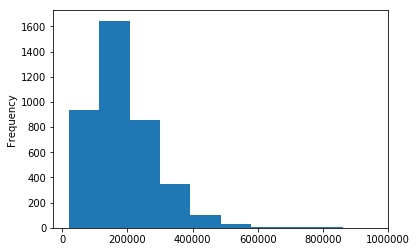

In [34]:
data["fnlwgt"].plot(kind="hist")
data["fnlwgt"].describe()

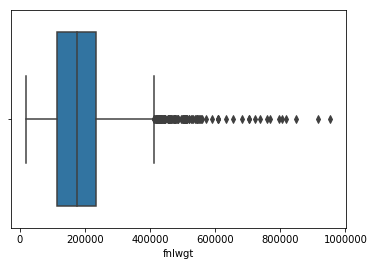

In [33]:
sns.boxplot('fnlwgt', data=data)

Ako môžeme vidieť, v tomto prípade sa outliery vyskytujú a to v hodnotách od cca 600000 do max, ktoré je 953588. Vychýlené hodnoty nahradíme 95 percentilom.

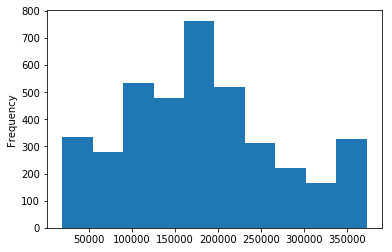

In [42]:
data["fnlwgt"] = data["fnlwgt"].clip( upper=data["fnlwgt"].quantile(0.95))
data["fnlwgt"].plot(kind="hist")


## Hodnoty agregovaných hodnôt cukrovky

### skewness

In [43]:
data["skewness_glucose"].isnull().sum()

1

TODO: nahradit priemerom zo segmentu

count    3932.000000
mean        4.219887
std         9.679111
min        -1.755332
25%        -0.119501
50%         0.374657
75%         2.083826
max        68.101622
Name: skewness_glucose, dtype: float64

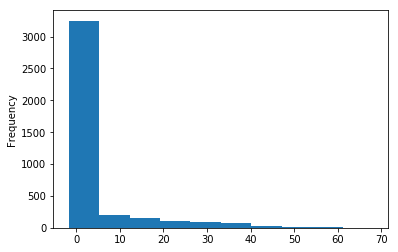

In [48]:
data["skewness_glucose"].plot(kind="hist")
data["skewness_glucose"].describe()

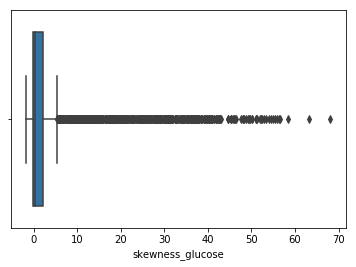

In [46]:
sns.boxplot('skewness_glucose', data=data)

TODO: zmenit na transformaciu

### mean

In [47]:
data["mean_glucose"].isnull().sum()

0

count    3933.000000
mean      101.277271
std        33.560209
min         6.187500
25%        87.742188
50%       110.664062
75%       124.132812
max       189.734375
Name: mean_glucose, dtype: float64

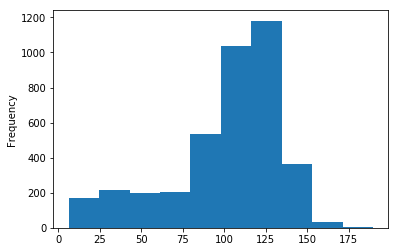

In [49]:
data["mean_glucose"].plot(kind="hist")
data["mean_glucose"].describe()

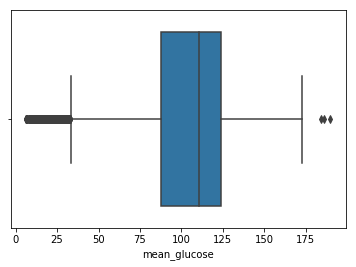

In [50]:
sns.boxplot('mean_glucose', data=data)

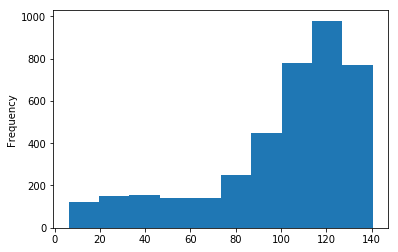

In [57]:
data["mean_glucose"]= data["mean_glucose"].clip( upper=data["mean_glucose"].quantile(0.95))
data["mean_glucose"].plot(kind="hist")

### kurtosis

In [58]:
data["kurtosis_glucose"].isnull().sum()

1

TODO: nahradit priemerom zo segmentu

count    3932.000000
mean        0.951380
std         1.611163
min        -1.641515
25%         0.072000
50%         0.310578
75%         0.777223
max         8.069522
Name: kurtosis_glucose, dtype: float64

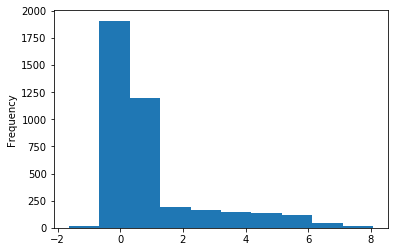

In [59]:
data["kurtosis_glucose"].plot(kind="hist")
data["kurtosis_glucose"].describe()

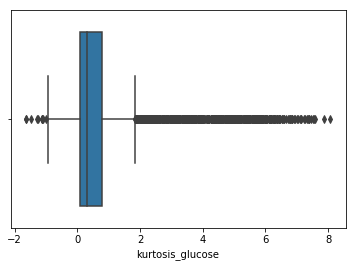

In [61]:
sns.boxplot('kurtosis_glucose', data=data)

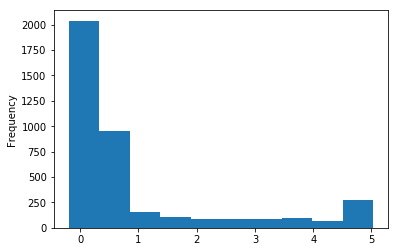

In [63]:
df= data["kurtosis_glucose"].clip(lower=data["kurtosis_glucose"].quantile(0.05), upper=data["kurtosis_glucose"].quantile(0.95))
df.plot(kind="hist")

NOTE: zmenit na transformaciu

### std

In [64]:
data["std_glucose"].isnull().sum()

0

count    3933.000000
mean       45.174684
std         7.607881
min        25.695250
25%        40.165726
50%        45.887420
75%        50.369068
max        91.206475
Name: std_glucose, dtype: float64

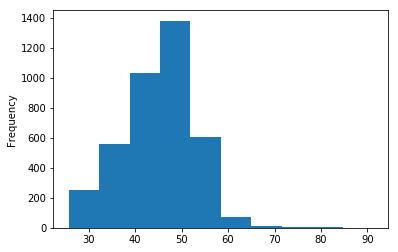

In [65]:
data["std_glucose"].plot(kind="hist")
data["std_glucose"].describe()

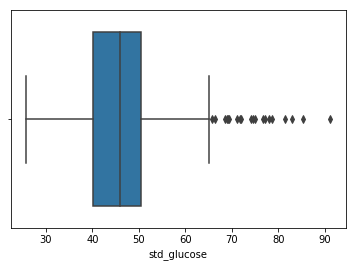

In [66]:
sns.boxplot('std_glucose', data=data)

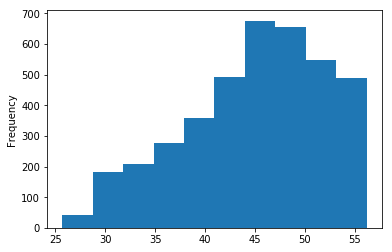

In [80]:
data["std_glucose"]= data["std_glucose"].clip( upper=data["std_glucose"].quantile(0.95))
data["std_glucose"].plot(kind="hist")

## hours_per_week

In [73]:
data["hours_per_week"].isnull().sum()

0

count    3933.000000
mean       40.129672
std        12.103234
min         1.000000
25%        40.000000
50%        40.000000
75%        45.000000
max        99.000000
Name: hours_per_week, dtype: float64

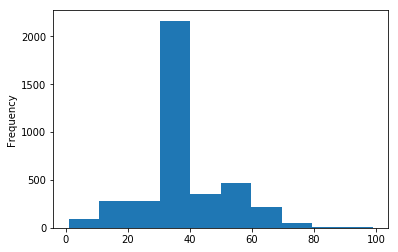

In [75]:
data["hours_per_week"].plot(kind="hist")
data["hours_per_week"].describe()

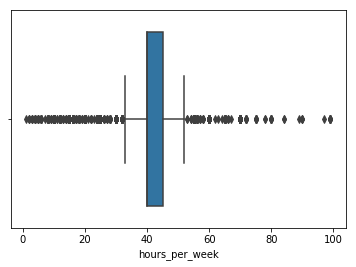

In [76]:
sns.boxplot('hours_per_week', data=data)

Nepamatas sa, co nam hovoril s tymto, ze co robit, ked tam niekto tych 99 hodin, ci to nechat alebo co?

## Agregovane hodnoty kyslika

### skewness

In [77]:
data["skewness_oxygen"].isnull().sum()

1

count    3932.000000
mean       91.297976
std       108.565808
min        -1.976976
25%        12.863954
50%        68.476815
75%       127.017151
max      1191.000837
Name: skewness_oxygen, dtype: float64

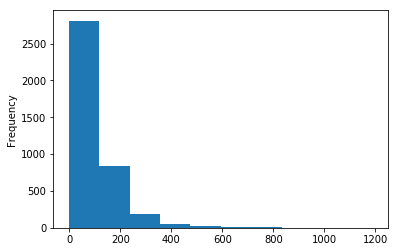

In [83]:
data["skewness_oxygen"].plot(kind="hist")
data["skewness_oxygen"].describe()

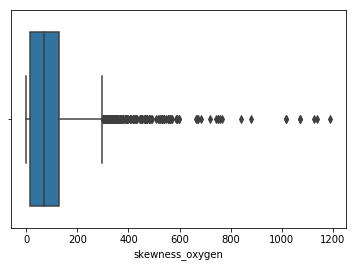

In [79]:
sns.boxplot('skewness_oxygen', data=data)

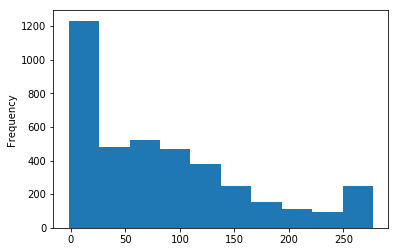

In [82]:
dff= data["skewness_oxygen"].clip( upper=data["skewness_oxygen"].quantile(0.95))
dff.plot(kind="hist")

NOTE: pouvazovat nad transformaciou

### mean

In [84]:
data["mean_oxygen"].isnull().sum()

1

count    3932.000000
mean       18.480697
std        34.792756
min         0.213211
25%         2.064799
50%         3.236622
75%        12.635452
max       217.371238
Name: mean_oxygen, dtype: float64

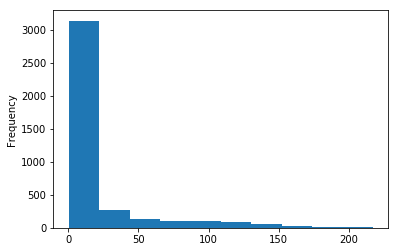

In [85]:
data["mean_oxygen"].plot(kind="hist")
data["mean_oxygen"].describe()

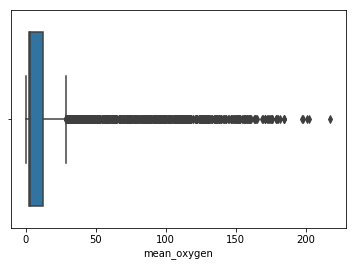

In [86]:
sns.boxplot('mean_oxygen', data=data)

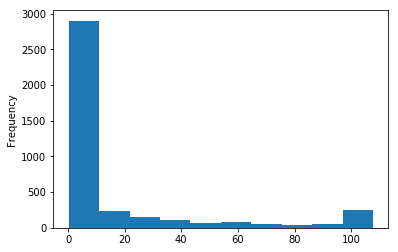

In [88]:
dff= data["mean_oxygen"].clip( upper=data["mean_oxygen"].quantile(0.95))
dff.plot(kind="hist")

### kurtosis

In [89]:
data["kurtosis_oxygen"].isnull().sum()

1

count    3932.000000
mean        7.413030
std         4.812690
min        -2.597872
25%         3.636259
50%         7.781903
75%        10.263412
max        34.539844
Name: kurtosis_oxygen, dtype: float64

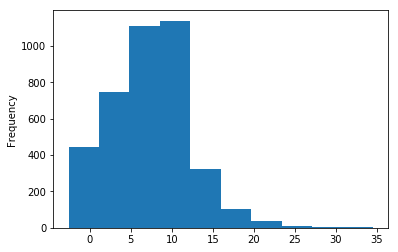

In [90]:
data["kurtosis_oxygen"].plot(kind="hist")
data["kurtosis_oxygen"].describe()

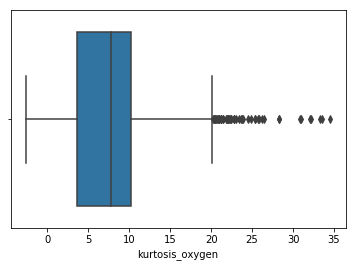

In [91]:
sns.boxplot('kurtosis_oxygen', data=data)

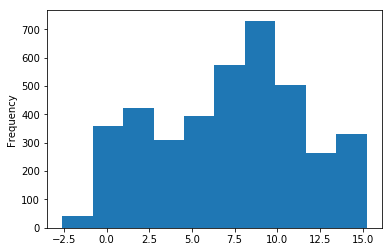

In [95]:
dff= data["kurtosis_oxygen"].clip( upper=data["kurtosis_oxygen"].quantile(0.95))
dff.plot(kind="hist")

### std

In [96]:
data["std_oxygen"].isnull().sum()

1

count    3932.000000
mean       31.156134
std        22.269386
min         7.370432
25%        15.039457
50%        20.564154
75%        43.229414
max       110.642211
Name: std_oxygen, dtype: float64

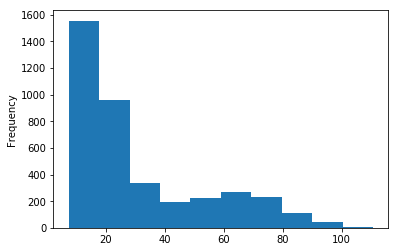

In [97]:
data["std_oxygen"].plot(kind="hist")
data["std_oxygen"].describe()

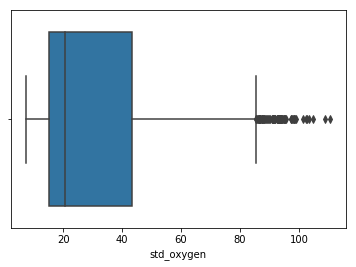

In [98]:
sns.boxplot('std_oxygen', data=data)

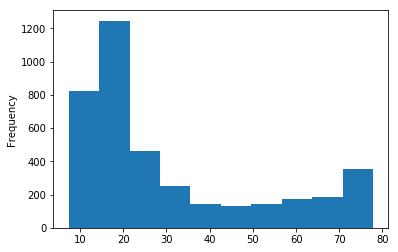

In [99]:
dff= data["std_oxygen"].clip( upper=data["std_oxygen"].quantile(0.95))
dff.plot(kind="hist")

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
name                3933 non-null object
state               3933 non-null object
age                 3933 non-null float64
sex                 3933 non-null object
birth_month         3933 non-null float64
race                3932 non-null object
marital_status      3540 non-null object
occupation          3695 non-null object
pregnant            3933 non-null float64
relationship        3933 non-null object
skewness_glucose    3932 non-null float64
mean_glucose        3933 non-null float64
kurtosis_glucose    3932 non-null float64
education           3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3933 non-null float64
income              3932 non-null object
native_country      3852 non-null object
hours_per_week      3933 non-null float64
workclass           3695 non-null object
mean_oxygen         3